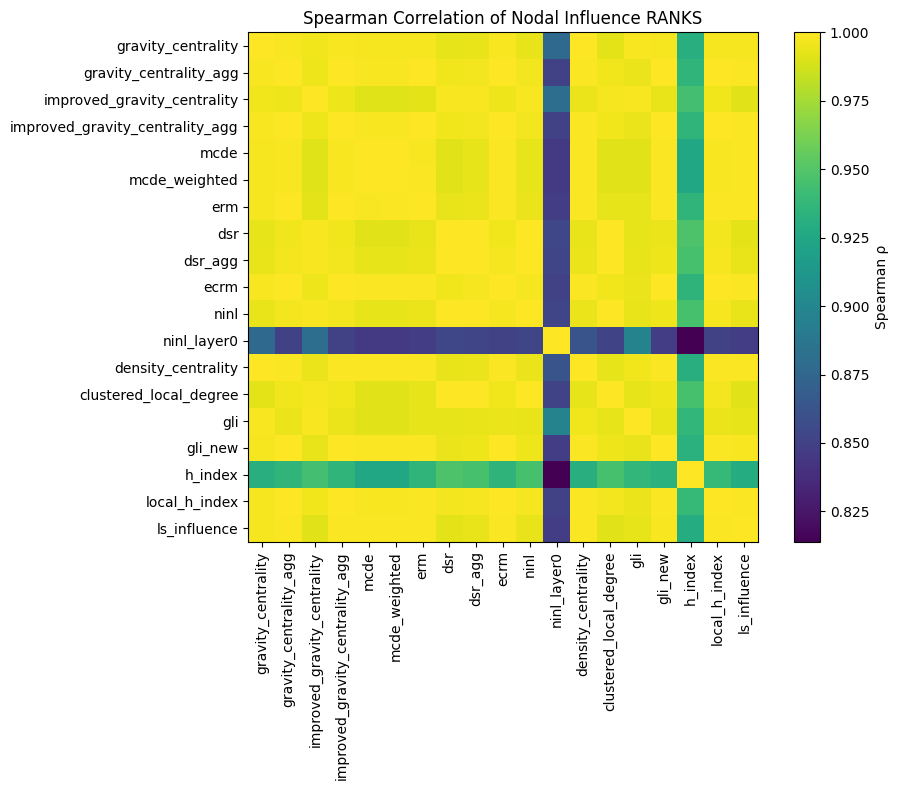

In [1]:
# (In the first cell of your notebook)

# 1) Ensure Python can import your local `vitalnodes` package.
#    If you typically run everything with `PYTHONPATH=src`, do:
import sys
import os

# Adjust the path below if your notebook lives under src/examples:
# we need the parent of "src" in sys.path so that "import vitalnodes" works.
repo_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# e.g. if cwd = ".../src/examples", repo_root becomes ".../"
sys.path.insert(0, os.path.join(repo_root, "src"))

# Now imports should work:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from vitalnodes.metrics import (
    gravity,
    entropy,
    ninl,
    density,
    gli,
    hindex,
    ls,
)

# 2) Re‐create the same ER graph of size 2 000 from your benchmark:
N = 2000
P = 0.05
G = nx.erdos_renyi_graph(N, P, seed=42)

# 3) Compute all measures (serially, by forcing parallel=False).
#    If you prefer multiprocessing, flip parallel=True and set processes as desired.

scores = {}
scores["gravity_centrality"] = gravity.gravity_centrality(G, parallel=False)
scores["gravity_centrality_agg"] = gravity.gravity_centrality_agg(G, parallel=False)
scores["improved_gravity_centrality"] = gravity.improved_gravity_centrality(G, parallel=False)
scores["improved_gravity_centrality_agg"] = gravity.improved_gravity_centrality_agg(G, parallel=False)

scores["mcde"] = entropy.mcde(G, parallel=False)
scores["mcde_weighted"] = entropy.mcde(G, weighted=True, parallel=False)
scores["erm"] = entropy.erm(G, parallel=False)
scores["dsr"] = entropy.dsr(G, parallel=False)
scores["dsr_agg"] = entropy.dsr_agg(G, parallel=False)
scores["ecrm"] = entropy.ecrm(G, parallel=False)

scores["ninl"] = ninl.ninl(G, parallel=False)
scores["ninl_layer0"] = ninl.ninl(G, layers=0, parallel=False)

scores["density_centrality"] = density.density_centrality(G, parallel=False)
scores["clustered_local_degree"] = density.clustered_local_degree(G, parallel=False)

scores["gli"] = gli.gli(G, parallel=False)
scores["gli_new"] = gli.gli_new(G, parallel=False)

scores["h_index"] = hindex.h_index(G, parallel=False)
scores["local_h_index"] = hindex.local_h_index(G, parallel=False)

scores["ls_influence"] = ls.ls_influence(G, parallel=False)

# 4) Build a DataFrame of raw scores (each column = one metric)
df_scores = pd.DataFrame({ name: pd.Series(vec) for name, vec in scores.items() })

# 5) Convert each column to ranks (highest‐score → rank 1, next → rank 2, …).
#    We do `df_scores.rank(ascending=False)` so that the largest value gets rank=1.
df_ranks = df_scores.rank(ascending=False, method="average")

# 6) Compute Spearman‐rank correlation (i.e. Pearson correlation on those ranks)
corr_matrix = df_ranks.corr(method="pearson")  # Spearman = corr of ranks

# 7) Display the correlation matrix as a DataFrame
corr_matrix

# 8) Plot a heatmap of that correlation matrix (with default matplotlib styling)
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix.values, interpolation="nearest")
plt.colorbar(label="Spearman ρ")
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.index)), corr_matrix.index)
plt.title("Spearman Correlation of Nodal Influence RANKS")
plt.tight_layout()
plt.show()


In [4]:
for key, val in scores.items():
    count = 0
    for node, score in val.items():
        print(key, node, score)
        count += 1
        if count == 5: break

gravity_centrality 0 3667988.25
gravity_centrality 1 3691984.5
gravity_centrality 2 3773769.75
gravity_centrality 3 3722982.75
gravity_centrality 4 3678950.25
gravity_centrality_agg 0 319688354.4444445
gravity_centrality_agg 1 334276659.6111111
gravity_centrality_agg 2 387302967.75
gravity_centrality_agg 3 353298637.1666667
gravity_centrality_agg 4 324279885.0
improved_gravity_centrality 0 4538499.75
improved_gravity_centrality 1 4564228.5
improved_gravity_centrality 2 4668338.25
improved_gravity_centrality 3 4604942.25
improved_gravity_centrality 4 4558365.0
improved_gravity_centrality_agg 0 394973239.5555555
improved_gravity_centrality_agg 1 412870837.3888889
improved_gravity_centrality_agg 2 478543070.0277778
improved_gravity_centrality_agg 3 436422132.5833334
improved_gravity_centrality_agg 4 400546635.4166666
mcde 0 166.18976232739683
mcde 1 170.1844356115546
mcde 2 184.1636899727072
mcde 3 175.234966374507
mcde 4 167.06335477530376
mcde_weighted 0 166.1111097548153
mcde_weighted 

In [ ]:
import networkx as nx, numpy as np
from vitalnodes.metrics import ninl, gravity
from scipy.stats import spearmanr

G = nx.karate_club_graph()
k = int(0.1 * G.number_of_nodes())          # top-5 %

scores = {
    'degree' : dict(G.degree()),
    'NINL-3' : ninl.ninl(G, layers=3, parallel=False),
    'Gravity': gravity.gravity_centrality(G, parallel=False),
}

for name, sc in scores.items():
    topk = sorted(sc, key=sc.get, reverse=True)[:k]
    # naive “influence”: sum of neighbours reached in 2 steps when you vaccinate top-k
    H = G.copy()
    H.remove_nodes_from(topk)
    remaining_size = len(max(nx.connected_components(H), key=len))
    print(f"{name:10s} | giant component after vaccinating top-{k}: {remaining_size}")


degree     | giant component after vaccinating top-1: 33
NINL-3     | giant component after vaccinating top-1: 33
Gravity    | giant component after vaccinating top-1: 27
